<a href="https://colab.research.google.com/github/DOOMNOVA/MultiNERD-English-/blob/main/MultiNERD_system_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# run cell to install packages
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install seqeval
!pip install evaluate
!pip install pipreqs
!pip install -U "huggingface_hub[cli]"
!pip install scikit-learn seaborn matplotlib


## Import the necessary packages

In [27]:
import numpy as np
import pandas as pd
import transformers
from datasets import load_dataset, load_metric
from transformers import DistilBertForTokenClassification, DistilBertTokenizerFast, TrainingArguments, Trainer , pipeline, DataCollatorForTokenClassification
import evaluate
#import wandb
#import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
"login to hugging face to upload model to hub later - uncomment code if needed"
#from huggingface_hub import notebook_login
#notebook_login(True)


## Load the MultiNERD dataset

In [3]:
# download the dataset
data = "Babelscape/multinerd"
dataset = load_dataset(data)



Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Preprocessing stage
### Specify labels, filter english examples and steps in instruction 5

In [4]:
#using only the 5 + O entity types
id2label = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-DIS": 9,
    "I-DIS": 10,
  }
label2id = {value: key for key, value in id2label.items()}
label_list = list(id2label.keys())





In [5]:
#Filter out non-english examples from all three splits of datasets
data_eng = dataset.filter(lambda x: x['lang']=='en')



Filter:   0%|          | 0/2678400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/334800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/335986 [00:00<?, ? examples/s]

### Instruction 5 preprocessing

In [6]:
#for preprocessing  and specifying zero ner_tags values for below entity types in the dataset
zero_entity_types =  {"B-BIO": 9, "I-BIO": 10, "B-CEL": 11,"I-CEL": 12,"B-EVE": 15, "I-EVE": 16,"B-FOOD": 17,"I-FOOD": 18,"B-INST": 19,
                      "I-INST": 20,"B-MEDIA": 21,"I-MEDIA": 22,"B-MYTH": 23,"I-MYTH": 24,"B-PLANT": 25,"I-PLANT": 26,"B-TIME": 27,"I-TIME": 28,"B-VEHI": 29,"I-VEHI": 30 }

# convert the ner_tag value to zero for entity types not needed in the dataset:
# change ner_tags for DIS entity types from 13,14  to 9,10 and 0 for the zero_entity_types
def convert_to_zero(data_ner):
  data_ner['ner_tags'] = [9 if tag == 13 else (10 if tag == 14 else (0 if tag in zero_entity_types.values() else tag)) for tag in data_ner['ner_tags']]
  return data_ner






In [7]:
# do pre-processing step in instruction 5
data_eng = data_eng.map(convert_to_zero)

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

## Tokenize and format function

In [8]:
#load tokenizer for distillbert
model_name = 'distilbert-base-cased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

#helper function for tokenizing and formating the ner dataset --- reference - code used from https://huggingface.co/docs/transformers/v4.35.2/en/tasks/token_classification#evaluate
def format_and_tokenize(dataset_eng):
  tokenized_inputs = tokenizer(dataset_eng['tokens'],truncation=True,is_split_into_words=True)

  labels = []
  for i, label in enumerate(dataset_eng[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None

        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

  tokenized_inputs["labels"] = labels

  return tokenized_inputs






tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [1]:
#format and tokenize the dataset
data_eng = data_eng.map(format_and_tokenize,batched=True)


NameError: ignored

## Define datacollator and function for computing a suite of metrics

In [13]:
datacollator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

#reference - code used from - https://huggingface.co/docs/transformers/v4.35.2/en/tasks/token_classification#evaluate

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]

    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],

        "recall": results["overall_recall"],

        "f1": results["overall_f1"],

        "accuracy": results["overall_accuracy"],
    }



## Finetuning to develop System B

In [14]:
#load system_B for fine tuning
system_B = DistilBertForTokenClassification.from_pretrained(model_name,num_labels = len(label_list),id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:

# specify training arguments
training_args = TrainingArguments(
    output_dir = './distilbert_system_B',
    per_device_train_batch_size = 32,
    per_device_eval_batch_size =  32,
    num_train_epochs = 3,
    weight_decay = 0.01,
    evaluation_strategy='epoch',
    save_strategy= 'epoch',
    load_best_model_at_end=True,
    learning_rate = 2e-5,

)

In [17]:
#fine-tuning system B
trainer = Trainer(
    model = system_B,
    args = training_args,
    train_dataset = data_eng['train'],
    eval_dataset = data_eng['validation'],
    tokenizer = tokenizer,
    data_collator = datacollator,
    compute_metrics = compute_metrics

)
trainer.train()


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.013400,0.020812,0.946595,0.948812,0.947703,0.992897
2,0.006700,0.023738,0.945324,0.952779,0.949037,0.993116
3,0.003100,0.029286,0.945564,0.953066,0.949300,0.993079


TrainOutput(global_step=24615, training_loss=0.01249195680781978, metrics={'train_runtime': 4982.1483, 'train_samples_per_second': 158.1, 'train_steps_per_second': 4.941, 'total_flos': 1.3385497529911296e+16, 'train_loss': 0.01249195680781978, 'epoch': 3.0})

In [18]:
#save model
trainer.save_model('./fine_tuned_system_B_ner')

## Test performance of System B with the Test set

In [19]:
#save test metric results
test_metrics = trainer.evaluate(data_eng['test'],metric_key_prefix='test')
trainer.save_metrics('test',test_metrics)

In [20]:
# test metrics for individual entity types

predictions, labels, _ = trainer.predict(data_eng["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'ANIM': {'precision': 0.7032146957520092,
  'recall': 0.763715710723192,
  'f1': 0.7322175732217574,
  'number': 3208},
 'DIS': {'precision': 0.7151819322459222,
  'recall': 0.7509881422924901,
  'f1': 0.7326478149100256,
  'number': 1518},
 'LOC': {'precision': 0.9920826735561297,
  'recall': 0.9900199600798403,
  'f1': 0.99105024351663,
  'number': 24048},
 'ORG': {'precision': 0.9621121718377088,
  'recall': 0.9746146872166818,
  'f1': 0.9683230746134214,
  'number': 6618},
 'PER': {'precision': 0.9882419874834061,
  'recall': 0.9897435897435898,
  'f1': 0.9889922186373126,
  'number': 10530},
 'overall_precision': 0.955618874929845,
 'overall_recall': 0.9640259570576194,
 'overall_f1': 0.9598040065909288,
 'overall_accuracy': 0.9935278438152871}

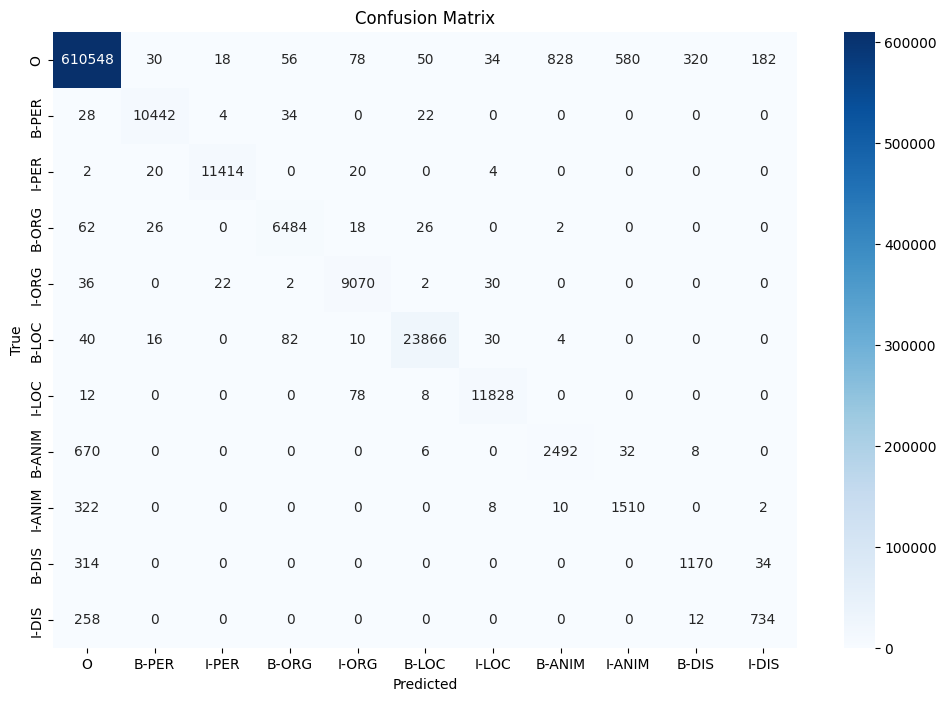

In [31]:
# plot the confusion matrix for the test dataset

# Flatten the lists
flat_true_labels = [label for sublist in true_labels for label in sublist]
flat_true_predictions = [label for sublist in true_predictions for label in sublist]

# Create a confusion matrix
conf_mat = confusion_matrix(flat_true_labels, flat_true_predictions, labels=label_list)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix_system_B.png')
plt.show()

In [26]:
# save the model to hugging face
trainer.push_to_hub()

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

events.out.tfevents.1702384777.c4d84df77466.1779.0:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

events.out.tfevents.1702389843.c4d84df77466.1779.1:   0%|          | 0.00/569 [00:00<?, ?B/s]

'https://huggingface.co/doomnova/distilbert_system_B/tree/main/'

In [33]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [34]:

# save pipe.pkl to output data folder
#!cp -r distilbert_system_B /content/drive/MyDrive/general